# Load dependencies and tables

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
output_tables = "output_tables"
run_dir_name = input(f"Enter the directory name of the ZOTU tables in the {output_tables} directory")
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

# Length of ZOTUs

,refseq_length
count,1523.000000
mean,315.577150
std,31.713709
min,204.000000
25%,296.000000
50%,306.000000
75%,326.000000
max,450.000000


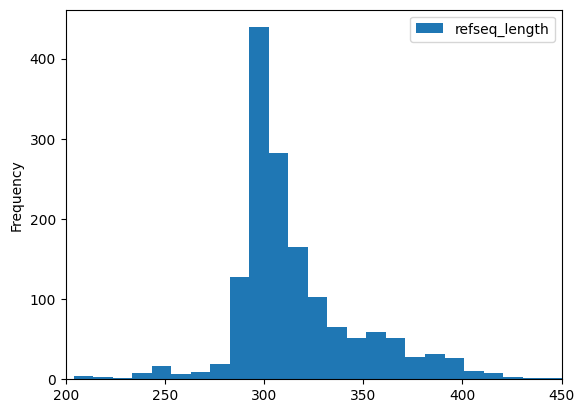

In [ ]:
# Length of derep ZOTUs

display(df_refseq_full.describe())
df_refseq_full.plot.hist(bins=25, xlim=(200, 450))
plt.show()


# Filter results

In [227]:
# Analyze difference in filter results after truncation
df = df_truncate_mapping
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
display(df.describe())

df_filter = df[['passed_abun_full', 'passed_contam_full']]
df_filter_counts = pd.DataFrame.join(df_filter.value_counts(), df_filter.value_counts(normalize=True))
print(f"Of all {df_filter.shape[0]} full length ZOTUs found across all samples:")
print(f"{df_filter_counts.loc[(True, slice(None))]['count'].sum()} passed the abundance filter")
print(f"{df_filter_counts.loc[(True, True)]['count']} passed the contamination filter")
display(df_filter_counts)

print("After truncation:")
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(df_trunc_counts)

df_not_trunc_filter = df[df["passed_trunc"] == False][['passed_abun_full', 'passed_contam_full']]
df_not_trunc_filter_counts = pd.DataFrame.join(df_not_trunc_filter.value_counts(), df_not_trunc_filter.value_counts(normalize=True))
print(f"Of the {df_not_trunc_filter.shape[0]} ZOTUs that do not pass truncation (<250bp):")
print(f"{df_not_trunc_filter_counts.loc[(True, True)]['count']} ZOTUs would have passed all filters without truncation")
display(df_not_trunc_filter_counts)

df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
print(f"Of all {df_trunc.shape[0]} truncated ZOTUs found across all samples:")
print(f"{df_trunc_filter_counts.loc[(True, slice(None))]['count'].sum()} passed the abundance filter")
print(f"{df_trunc_filter_counts.loc[(True, True)]['count']} passed the contamination filter")
display(df_trunc_filter_counts)

df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_contam_full', 'passed_abun_trunc', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_contam_full', 'passed_abun_trunc', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts = df_abun_compare_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_full', 'passed_contam_full', 'passed_abun_trunc', 'passed_contam_trunc']), rsuffix=" derep")
print("Comparing the abundance and contamination filters after truncation:")
print(f"{df_abun_compare_counts.loc[(False, slice(None), True, slice(None))]['count'].sum()} ZOTUs pass the abundance filter only when truncated")
print(f"{df_abun_compare_counts.loc[(slice(None), False, slice(None), True)]['count'].sum()} ZOTUs pass the contamination filter only when truncated")
print("There are no ZOTUs that did not pass the contamination filter after truncation when they would have had at full length")
display(df_abun_compare_counts)

df_new_abun = df[(df['passed_abun_full'] == False) & (df['passed_abun_trunc'] == True)][['srr_name', 'trunc_zotu_id']]
df_new_abun = df_new_abun.merge(df_trunc_derep[df_trunc_derep['passed_abun_full'] == True][['srr_name', 'trunc_zotu_id']], how='left', indicator=True)
df_new_abun['new_zotu'] = df_new_abun['_merge'] == 'left_only'
df_new_abun = df_new_abun.drop(columns=['_merge'])
df_new_abun_counts = pd.DataFrame.join(
    df_new_abun.value_counts(subset=['new_zotu']),
    df_new_abun.drop_duplicates().value_counts(subset=['new_zotu']), rsuffix=" derep")
display(df_new_abun_counts)
#display(df_new_abun.groupby(['srr_name', 'trunc_zotu_id']).size())


,srr_name,zotu_id,trunc_zotu_id,passed_trunc,passed_abun_full,passed_contam_full,passed_abun_trunc,passed_contam_trunc
count,65596,65596,64280,65596,65596,65596,64280,64280
unique,190,868,855,2,2,2,2,2
top,NBCLAB4208,Zotu1,Zotu18,True,False,False,False,False
freq,868,190,202,64280,59472,60479,57653,58876


Of all 65596 full length ZOTUs found across all samples:
6124 passed the abundance filter
5117.0 passed the contamination filter


count  proportion
passed_abun_full passed_contam_full                   
False            False               59472    0.906641
True             True                 5117    0.078008
                 False                1007    0.015352

After truncation:


,count,proportion,count derep
passed_trunc,,,
True,64280,0.979938,61373.0
False,1316,0.020062,NaN


Of the 1316 ZOTUs that do not pass truncation (<250bp):
44.0 ZOTUs would have passed all filters without truncation


count  proportion
passed_abun_full passed_contam_full                   
False            False                1254    0.952888
True             True                   44    0.033435
                 False                  18    0.013678

Of all 64280 truncated ZOTUs found across all samples:
6627 passed the abundance filter
5404.0 passed the contamination filter


count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                   
False             False                57653    0.896904        55247   
True              True                  5404    0.084070         5129   
                  False                 1223    0.019026          997   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.083571  
                  False                        0.016245

Comparing the abundance and contamination filters after truncation:
565 ZOTUs pass the abundance filter only when truncated
331 ZOTUs pass the contamination filter only when truncated
There are no ZOTUs that did not pass the contamination filter after truncation when they would have had at full length


count  \
passed_abun_full passed_contam_full passed_abun_trunc passed_contam_trunc          
False            False              False             False                57653   
True             True               True              True                  5073   
                 False              True              False                  989   
False            False              True              True                   331   
                                                      False                  234   

                                                                           proportion  \
passed_abun_full passed_contam_full passed_abun_trunc passed_contam_trunc               
False            False              False             False                  0.896904   
True             True               True              True                   0.078920   
                 False              True              False                  0.015386   
False            False              True              True                   0.005149   
                                                      False                  0.003640   

                                                                           count derep  
passed_abun_full passed_contam_full passed_abun_trunc passed_contam_trunc               
False            False              False             False                      55247  
True             True               True              True                        5024  
                 False              True              False                        938  
False            False              True              True                         105  
                                                      False                         59

,count,count derep
new_zotu,,
False,286,230
True,279,164
